# Case Study: Neural Style Transfer

<img src="https://github.com/ijoseff/ijoseff.github.io/blob/master/assets/img/portfolio/neural.png?raw=true" width = "800" height = "400" />

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-Study:-Neural-Style-Transfer" data-toc-modified-id="Case-Study:-Neural-Style-Transfer-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case Study: Neural Style Transfer</a></span></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Overview" data-toc-modified-id="Overview-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Codes-&amp;-Algorithm" data-toc-modified-id="Codes-&amp;-Algorithm-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Codes &amp; Algorithm</a></span><ul class="toc-item"><li><span><a href="#Libraries,-Parameters,-Content-And-Style,-Layer-Weights" data-toc-modified-id="Libraries,-Parameters,-Content-And-Style,-Layer-Weights-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Libraries, Parameters, Content And Style, Layer Weights</a></span></li><li><span><a href="#Transfer-Learning-Architecture" data-toc-modified-id="Transfer-Learning-Architecture-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Transfer Learning Architecture</a></span></li><li><span><a href="#Image-Preprocessing" data-toc-modified-id="Image-Preprocessing-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Image Preprocessing</a></span></li><li><span><a href="#Function-Settings" data-toc-modified-id="Function-Settings-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Function Settings</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Model Training</a></span></li><li><span><a href="#Result" data-toc-modified-id="Result-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Result</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

# Introduction

Neural style transfer is an optimization technique used to take two images, a content image, a style reference image (such as an artwork by a famous painter), and blend them together such that the input image is transformed to look like the content image, but “painted” in the style of the style image.

Deep neural networks have already surpassed human level performance in tasks such as object recognition and detection. However, deep networks were lagging far behind in tasks like generating artistic artefacts having high perceptual quality until recent times. Creating better quality art using machine learning techniques is imperative for reaching human-like capabilities, as well as opens up a new spectrum of possibilities. And with the advancement of computer hardware as well as the proliferation of deep learning, deep learning is right now being used to create art. In this project, an AI will attempt to generate art based on two images as reference.

**Dataset:**
 - Random artsy photo
 - Joseff's photo

# Overview

<img src="https://github.com/ijoseff/Neural-Style-Transfer/blob/master/overview.png?raw=true" width = "600" height = "400" />

# Codes & Algorithm

## Libraries, Parameters, Content And Style, Layer Weights

In [1]:
# Import libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

# Set Parameters
lr = 7.0
size = 224
iterations = 800
style_wt = 1e5
content_wt = 1.0
 
# Specify content and style
content_image_path = "content.jpg"
style_image_path = "style.png"
 
# Check TensorFlow version
print("TensorFlow version:", tf.__version__)
 
# Style layer weights
style_layer_wts = [1.0, 0.8, 0.1, 0.1, 0.2]

TensorFlow version: 2.3.0


## Transfer Learning Architecture

In [2]:
# Transfer learning using VGG19
model = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(size, size, 3))

# Freeze parameters
model.trainable = False

# Check model summary
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Image Preprocessing

In [3]:
# Image processing function
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(size, size))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return np.expand_dims(img, axis = 0)

In [4]:
# Image deprocessing function
def deprocess(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Set display function
def display_image(image):
    if len(image.shape) == 4:
        image = image[0,:,:,:]

    img = deprocess(image)
    
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()

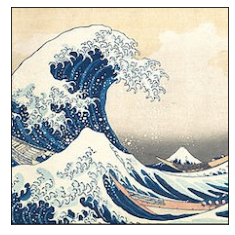

In [5]:
# Show style image
display_image(preprocess_image('style.jpg'))

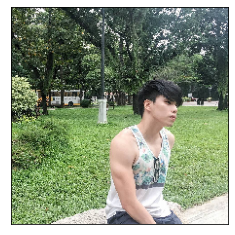

In [6]:
# Show content image
display_image(preprocess_image('content.jpg'))

## Function Settings

In [7]:
# Set content layer
content_layer = 'block4_conv2'

# Model architecture
content_model = tf.keras.models.Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

In [8]:
# Specify style layers
style_layers = [
    'block1_conv1', 'block1_conv2',
    'block2_conv1', 'block2_conv2',
    'block3_conv1'
    ]

# Set Style model
style_models = [
    tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer).output)
    for layer in style_layers
]

In [9]:
# Default setting
def content_cost(content_img, generated_img):
    C = content_model(content_img)
    G = content_model(generated_img)
    cost = tf.reduce_mean(tf.square(C - G))
    return cost

In [10]:
# Default setting
def gram_matrix(M):
    num_channels = tf.shape(M)[-1]
    M = tf.reshape(M, shape=(-1, num_channels))
    n = tf.shape(M)[0]
    G = tf.matmul(tf.transpose(M), M)
    return G / tf.cast(n, dtype=tf.float32)

In [11]:
# Default setting
def style_cost(style_img, generated_img):
    total_cost = 0
    
    for i, style_model in enumerate(style_models):
        S = style_model(style_img)
        G = style_model(generated_img)
        GS = gram_matrix(S)
        GG = gram_matrix(G)
        current_cost = style_layer_wts[i] * tf.reduce_mean(tf.square(GS - GG))
        total_cost += current_cost
    
    total_cost /= (size * size * len(style_models))
    return total_cost

## Model Training

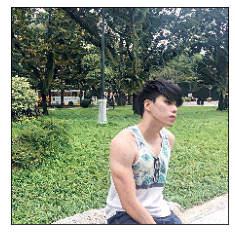

Iteration:1/800, Total Cost:533314688.0, Style Cost: 5333.14697265625, Content Cost: 0.0


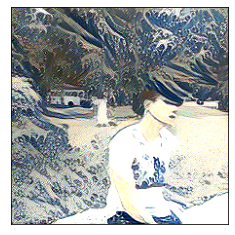

Iteration:101/800, Total Cost:1713086.5, Style Cost: 11.411103248596191, Content Cost: 571976.1875


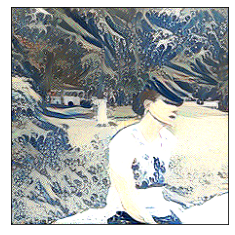

Iteration:201/800, Total Cost:1116391.5, Style Cost: 6.026097297668457, Content Cost: 513781.6875


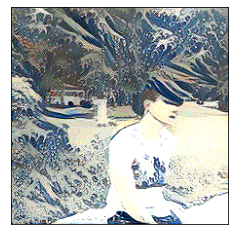

Iteration:301/800, Total Cost:923462.625, Style Cost: 4.437932014465332, Content Cost: 479669.46875


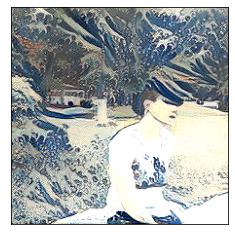

Iteration:401/800, Total Cost:822088.75, Style Cost: 3.644278049468994, Content Cost: 457660.90625


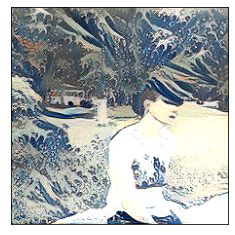

Iteration:501/800, Total Cost:758113.1875, Style Cost: 3.164820909500122, Content Cost: 441631.09375


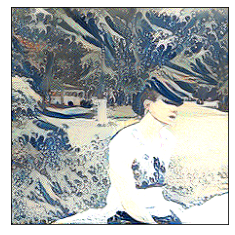

Iteration:601/800, Total Cost:713843.25, Style Cost: 2.840486526489258, Content Cost: 429794.625


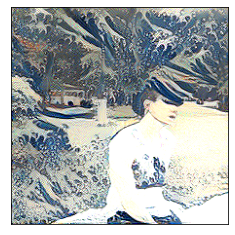

Iteration:701/800, Total Cost:680795.5625, Style Cost: 2.6048810482025146, Content Cost: 420307.4375


In [12]:
# Label data
content_image_preprocessed = preprocess_image('content.jpg')
style_image_preprocessed = preprocess_image('style.jpg')
generated_image = tf.Variable(content_image_preprocessed, dtype=tf.float32)

# Create empty list
generated_images = []
costs = []

# Set optimizer
optimizer = tf.optimizers.Adam(learning_rate=lr)

# Initiate style transfer
for i in range(iterations):
    
    with tf.GradientTape() as tape:
        J_content = content_cost(content_img=content_image_preprocessed, generated_img=generated_image)
        J_style = style_cost(style_img=style_image_preprocessed, generated_img=generated_image)
        J_total = content_wt * J_content + style_wt * J_style
    
    gradients = tape.gradient(J_total, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    
    costs.append(J_total.numpy())
    
    # Show results after a certain number of iterations
    if i % 100 == 0:
        display_image(generated_image.numpy())
        generated_images.append(generated_image.numpy())
        print("Iteration:{}/{}, Total Cost:{}, Style Cost: {}, Content Cost: {}".format(i+1, iterations, J_total, J_style, J_content))

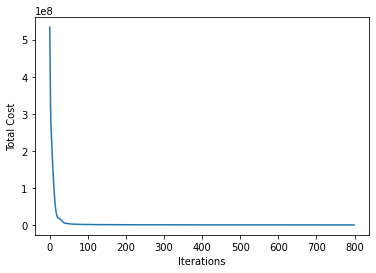

In [13]:
# Create plot
plt.plot(range(iterations), costs)
plt.xlabel("Iterations")
plt.ylabel("Total Cost")
plt.show()

In [14]:
# Deprocess image
image = Image.fromarray(deprocess(generated_images[-1][0]))

## Result

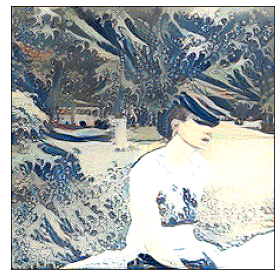

In [15]:
# Show output image
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('out.png')

# Conclusion

The model training was too long. It is recommended to this kind of project in a computer with high specification specifically with high GPUs or use Google colab for their free TPU. Overall, the result image is nice. It can be concluded that AI can also generate art. :)